In [1]:
#!pip uninstall visualkeras

In [2]:
#!pip install scikit-learn

In [3]:
#!pip install tensorflow-gpu

In [4]:
#!pip install pandas

In [5]:
#!pip install wandb

In [6]:
#!pip install numpy

In [7]:
#!pip install openpyxl

In [8]:
#Manejo de Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#Machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Librerias estandar (Extras)
import re
import os
import time
import random
from datetime import datetime

In [9]:
"""
DIRECTORIOS DEL PROYECTO
"""
path_base = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis'   # Directorio del proyecto
path_imagenes = 'F:/GOES/'                                         # Directorio de las imagenes procesadas
listDataset = [f'{path_base}/Archivos/Dataset/datasetMuestra.csv']          # Directorio(s) de los datos de precipitacion

In [10]:
!python --version
print(tf. __version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Limitamos el GPU, en caso se necesite
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

Python 3.9.11
2.8.0
Num GPUs Available:  1


In [11]:
#conda list cudnn

In [12]:
#conda list cudatoolkit

In [13]:
"""
Metodos para realizar el entrenamient - evaluacion del modelo
"""

'\nMetodos para realizar el entrenamient - evaluacion del modelo\n'

In [14]:

#Lee el archivo "filename" de datos de precipitacion y
#regresa un df que facilite la lectura del dataset para el entrenmaiento
def obtenerDatos(filename):
    start_time = time.time()
    pdata = pd.read_csv(filename)
    
    # Quitamos los valores NA
    pdata = pdata[pdata['dato'].notna()]

    # Definimos un solo tipo (str) pora asi poder convertirlo a tensor
    pdata = pdata.astype({"dato": str, "XO": str, "XA": str, "fecha": str})

    #Definimos la nueva columna para guardar el XO, XA y fecha
    pdata['imagen'] = pdata.apply(obtenerDir, axis=1)

    # Seleccionamos solo las columnas necesarias :
    # precipitacion, Estacion (Longitud), Estacion (Latitud), Fecha (año-mes-dia-hora)
    #pdataX = pdata.loc[:, ['dato','umbral','altura', 'imagen', 'fecha']]
    pdata = pdata.astype({"dato": str, "umbral": str, "altura": str, "imagen": str, "fecha": str})

    # Barajeamos los datos
    pdata = shuffle(pdata)

    print(f'{len(pdata)} datos leidos')
    print("Tiempo tomado en leer datos: %.2fs" % (time.time() - start_time))
    return pdata

In [15]:

# Devuelve una lista con lo indices que no se encontraron lso archivos y el producto
# Servira para ver si se teinen todas los frames de la fecha
def comprobarFrames(dfOrignial, path_base, products, times, delete=1):
    
    #dfOrignial = obtenerDatos(datafile)
    
    
    start_time = time.time()
    
    dfTotal = pd.unique(dfOrignial['fecha'])
    no_fecha = []
    for fecha in dfTotal:
        year, month, day, hour = fecha.split('-')
        existe = True
        for p in products:
            for t in range(len(times)):             
                filename = f'{path_base}PNG/{fecha}/{fecha}_{t}.png'
                try:                    
                    file_size = os.path.getsize(filename)
                    existe = file_size > 4100000
                except: 
                    existe = False
                    break
                
            if not existe:
                break
        if not existe:
            no_fecha.append(fecha)
            

    if delete:
        antes = len(dfOrignial)
        df2 = dfOrignial[~dfOrignial['fecha'].isin(no_fecha)]
        despues = len(df2)
        print(f'{antes - despues}/{antes} datos eliminados: No se encontraron los archivos de imagenes satelitales')
    else:
        df2 = dfOrignial

    print("Tiempo tomado en verificar datos: %.2fs" % (time.time() - start_time))
    return df2, no_fecha

In [16]:
#Del dataset guardamos los datos mas importantes en una columna para facilitar su lectura
def obtenerDir(row):
    fecha = row['fecha']

    year, month, day, hour = fecha.split('-')
    # filename = f'{path_base}comprimido/{year}_{month}_{day}/{hour}/'
    return f"{row['XO']}--{row['XA']}--{fecha}"

In [17]:
def limpiarDatos(listNames, path_imagenes, products, times ,ceros = 0.0 ,delete=1):
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    for name in listNames:
        try:
            df.append(pd.read_csv(name))   
        except:
            print(f'No se pudo leer el archivo {name} de dataset')
            return -1
        
    if len(df)>2:
        dsCompleto =  pd.concat(df, ignore_index=True) 
    else:
        dsCompleto =  df[0]
        
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    # Quitamos los NA valores
    print(f'\nSe elimnara los valores nulos y dudosos')
    dsCompleto.dropna(subset=['dato'], axis='index', inplace=True)    
    dsCompleto = dsCompleto[dsCompleto['flag']!='ND']
    dsCompleto = dsCompleto[dsCompleto['flag'].isin(['C0000001','C0000002'])]
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos luego de elimnar nulos {len(dsCompleto)}')
              
    
    # Buscamos imagenes satelitales para lso archivos
    print(f'\nSe buscara las imagenes satelitales para los datos...')
    dfImagenes, no_fecha = comprobarFrames(dsCompleto, path_imagenes, products, times, delete)    
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
       
        
        
    #Limitamos la cantidad de ceros
    if ceros:
        print(f'\nSe limitara el numero de ceros al {ceros*100:.2f} porciento...')
        dsNoNulo = dfImagenes[dfImagenes['dato']!=0]
        dsNulo = dfImagenes[dfImagenes['dato']==0]
        dsNulo = dsNulo.sample(n=int(ceros*len(dsNoNulo)))        
        dfImagenes = pd.concat([dsNoNulo,dsNulo], ignore_index=True) 
        print(f'+Cantidad de datos luego de limtar ceros {len(dfImagenes)}')
    
    #Agregamos lso datos de las estaciones al dataset
    print(f'\nSe agregara los datos de las estaciones(cordenadas, umbral)...')
    dfImagenes['imagen'] = dfImagenes.apply(obtenerDir, axis=1)        
    print(f'-------> CANTIDAD FINAL DE DATOS :  {len(dfImagenes)} <--------------')  
    print("Tiempo total: %.2fs" % (time.time() - start_time))
    return shuffle(dfImagenes), no_fecha

In [18]:
def crearModelo2D(p,run):    
    print(f"Creadno modelo con input ({p['margen'][run]},{p['margen'][run]},{p['canales'][run]})) tipo ({p['outputs']})")
    # Imagen
    input_1 = tf.keras.layers.Input(shape=(p['margen'][run],p['margen'][run],p['canales'][run]))
    
    # Convulutional layers
    rescaling = tf.keras.layers.Rescaling(1./65536)(input_1)
    conv2d_1 = tf.keras.layers.Conv2D(128, kernel_size=3,activation=tf.keras.activations.relu)(rescaling)
    mxPool_1 = tf.keras.layers.MaxPooling2D()(conv2d_1)
    dropout_1  = tf.keras.layers.Dropout(0.2)(mxPool_1)
    
    conv2d_2 = tf.keras.layers.Conv2D(64, kernel_size=3,activation=tf.keras.activations.relu)(dropout_1)
    mxPool_2 = tf.keras.layers.MaxPooling2D()(conv2d_2)
    dropout_2  = tf.keras.layers.Dropout(0.1)(mxPool_2)
    
    conv2d_3 = tf.keras.layers.Conv2D(32, kernel_size=3,activation=tf.keras.activations.relu)(dropout_1)
    mxPool_3 = tf.keras.layers.MaxPooling2D()(conv2d_3)
    dropout_3  = tf.keras.layers.Dropout(0.2)(mxPool_3)
    
    conv2d_4 = tf.keras.layers.Conv2D(64, kernel_size=3,activation=tf.keras.activations.relu)(dropout_3)
    mxPool_4 = tf.keras.layers.MaxPooling2D()(conv2d_4)
    dropout_4  = tf.keras.layers.Dropout(0.2)(mxPool_4)
    
    conv2d_5 = tf.keras.layers.Conv2D(32, kernel_size=3,activation=tf.keras.activations.relu)(dropout_4)
    
    
    # Flatten layer :
    flatten = tf.keras.layers.Flatten()(conv2d_5)
    
    final = flatten
    listConcat = [flatten]
    listInputs = [input_1]
    
    if len(p['inputs'])>1:
        #Agregamos los otros atrbutos        
        for attr in p['inputs'][1:]:
            # The other input
            input_x = tf.keras.layers.Input(shape=(1,))
            listConcat.append(input_x)
            listInputs.append(input_x)

            
        # Concatenate
        final = tf.keras.layers.Concatenate()(listConcat)
        
    dense_1 = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(final)
    dense_2 = tf.keras.layers.Dense(units=16, activation=tf.keras.activations.relu)(dense_1)
    dense_3 = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(dense_2)
    
        
    # output
    if p['outputs'] == 'dato':
        output = tf.keras.layers.Dense(units=1)(dense_3)
        dimOutput = 1
    elif p['outputs'] == 'umbral':
        output = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(dense_3)
        dimOutput = 2
    else:
        print(f"No se pudo crear el modelo outputs no esta bien definido {p['outputs']}")
        return -1      
    

    full_model = tf.keras.Model(inputs=listInputs, outputs=[output])
    
    print('DONE')
    
    #print(full_model.summary())
    return full_model

In [19]:
def crearModelo3D(p,run):    
    print(f"Creando modelo con input ({p['tiempos'][run]},{p['margen'][run]},{p['margen'][run]},{p['canales'][run]})) y ({p['outputs']})...")
    # Imagen
    input_1 = tf.keras.layers.Input(shape=(p['tiempos'][run],p['margen'][run],p['margen'][run],p['canales'][run]))
    
    # first conv layer :
    conv3d_1 = tf.keras.layers.Conv3D(64, kernel_size=3,activation=tf.keras.activations.relu)(input_1)

    # Second conv layer :
    conv3d_2 = tf.keras.layers.Conv3D(32, kernel_size=3,activation=tf.keras.activations.relu)(conv3d_1)
    
    # Flatten layer :
    flatten = tf.keras.layers.Flatten()(conv3d_2)
    
    final = flatten
    listConcat = [flatten]
    listInputs = [input_1]
    
    if len(p['inputs'])>1:
        #Agregamos los otros atrbutos        
        for attr in p['inputs'][1:]:
            # The other input            
            input_x = tf.keras.layers.Input(shape=(1,))
            listConcat.append(input_x)
            listInputs.append(input_x)
            
        # Concatenate
        final = tf.keras.layers.Concatenate()(listConcat)
        
        
    # output
    if p['outputs'] == 'dato':
        output = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.softmax)(final)
        dimOutput = 1
    elif p['outputs'] == 'umbral':
        output = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.sigmoid)(final)
        dimOutput = 2
    else:
        print(f"No se pudo crear el modelo outputs no esta bien definido {p['outputs']}")
        return -1          

    full_model = tf.keras.Model(inputs=listInputs, outputs=[output])
    
    
    print('DONE')
    #print(full_model.summary())
    return full_model

In [20]:
def crearModelo(params,run):     
    if params['tiempos'][run] == 1:
        #Se crea un modelo conv2D
        return crearModelo2D(params,run)         
    else:
        #Se crea un modelo conv3D
        #return crearModelo2D(params,run)       
        return crearModelo2D(params,run)       

In [21]:
#Transformamos un filename tensor en una imagen
def read_png_file(item, value, p,run, path_base, products, times):
    # imagenData[0] = XO     # imagenData[1] = XA     # imagenData[2] = Fecha
    imagenData = tf.strings.split(item['imagen'], sep='--')
    size = int(p['margen'][run] / 2)

    timeJoin = []
    for j in range(p['tiempos'][run]-1,-1,-1):
        filename = path_base + 'PNG/' + imagenData[2] + '/' + imagenData[2] + '_' + str(j) + '.png'
        
        image_string = tf.io.read_file(filename)

        img_decoded = tf.io.decode_png(image_string, dtype=tf.uint16, channels=3)
        
        
                
        timeJoin.insert(0,img_decoded[int(imagenData[1]) - size:int(imagenData[1]) + size,
                                      int(imagenData[0]) - size:int(imagenData[0]) + size,
                                      0:p['canales'][run]])
 
        
    if p['tiempos'][run]==1:
        imagenData = tf.reshape(timeJoin[0],(p['margen'][run],p['margen'][run],p['canales'][run]))
    else:
        #img = tf.stack(timeJoin, axis=0)
        img = tf.reduce_mean( timeJoin , axis=0 )
        imagenData = tf.reshape(img,(p['margen'][run],p['margen'][run],p['canales'][run]))
        
    
    
    if len(p['inputs']) == 1:
        return imagenData, int(value)
    
    item['imagen'] = imagenData
    itemL = []
    for inpL in p['inputs']:
        itemL.append(item[inpL])
    
    return tuple(itemL), int(value)

In [22]:
def getMetrics(modelType, lr, paciencia):
    
    if modelType == 'umbral':    
        optimizer = keras.optimizers.Adam(learning_rate=lr) 
        loss_fn=keras.losses.BinaryCrossentropy()       
        train_acc_metric = keras.metrics.BinaryCrossentropy()
        val_acc_metric = keras.metrics.BinaryCrossentropy()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=paciencia, mode="max")  
 
        
        metrics = ['acc', tf.keras.metrics.TruePositives(),
                         tf.keras.metrics.TrueNegatives(),
                         tf.keras.metrics.FalsePositives(),
                         tf.keras.metrics.FalseNegatives()]
        

    elif modelType == 'dato':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        loss_fn=keras.losses.MeanSquaredError()
        train_acc_metric = keras.metrics.MeanSquaredError()
        val_acc_metric = keras.metrics.MeanSquaredError()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mse", patience=paciencia, mode="max")                                            
        metrics = ['mse']
        
        
    else:
        print('No se pudo crear las metricas')
        return -1    
         
        
    logs = Callback()
    callbacks = [early_stopping, logs]                     
        
    metrics = {'optimizer': optimizer, 'loss_fn':loss_fn,'train_acc_metric': train_acc_metric,
               'val_acc_metric': val_acc_metric, 'metrics': metrics,'callbacks': callbacks}
    
    return metrics
        

In [23]:
def splitDataset(p, run, dataset, path_imagenes, products, times,val_split= 0.2):
    #Dataset de etnrenamiento
    if p['dataset']:
        train, test = train_test_split(dataset.sample(frac=p['dataset']), test_size=val_split, shuffle=True)
    else:
        train, test = train_test_split(dataset, test_size=val_split, shuffle=True)
    print(f'Tamaño del dataset: Train {len(train)}  - Val {len(test)}')
    
    inputsList = {}
    for inp in p['inputs']:
        inputsList[inp] = train[inp].tolist()
        
       
        
    train_dataset = tf.data.Dataset.from_tensor_slices(((inputsList),train[p['outputs']].tolist()))           
    val_dataset = tf.data.Dataset.from_tensor_slices(((inputsList),train[p['outputs']].tolist()))     
    
    train_dataset = train_dataset.map(lambda x ,y : read_png_file(x,y,p,run,path_imagenes,products,times))
    val_dataset = val_dataset.map(lambda x ,y : read_png_file(x,y,p,run,path_imagenes,products,times))
    
    train_dataset = train_dataset.batch(p['batch'])#.cache().prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(p['batch'])#.prefetch(tf.data.AUTOTUNE)  
    
    return train_dataset, val_dataset

In [24]:
def trainModel(params,dataset,path_imagenes, path_base ,products, times, graficos=0,val_split=0.2,):
        
    config = dict(learning_rate=params['lr'], epochs = params['epocas'],
                     batch_size =params['batch'],architecture="CNN",)
    resultados = [] 
    for run in range(params['runs']):       
        print('--------------------------------------------------')
        print(f'Inicio de la prueba N°: {run+1}/{params["runs"]}') 
        
        #Metricas y parametros de entrenaiento
        metricas = getMetrics(params['outputs'], params['lr'], params['paciencia'])         

        #Modelo 
        model = crearModelo(params,run)        
        model.compile(optimizer=metricas['optimizer'],loss=metricas['loss_fn'],metrics=metricas['metrics'],)
    
        #Dataset        
        train_dataset, val_dataset = splitDataset(params,run, dataset, path_imagenes, products, times, val_split)
                
        
               
        #print(f'- Cantidad de dataset {len(train_dataset) * params["batch"]}')
        print(f'- Batch size:  {params["batch"]}')
    
        
        idModel = datetime.today().strftime("%Y%m%d_%H%M%S")
        checkpoint_path = f'{path_base}/Archivos/Modelos/Model_{idModel}.hdf5' 

        # Create a callback that saves the model's weights
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         verbose=1)

        if graficos:
            metricas['callbacks'].append(cp_callback)
            wandb.init(project=f'TesisDiegoV2({params["outputs"]}-{len(params["inputs"])})',
                       config=config,
                       name= f'Ex-{params["dataset"]}_({params["canales"][run]}-{params["tiempos"][run]}-{params["margen"][run]})_{idModel}')             
            metricas['callbacks'].append(WandbCallback(save_weights_only=True))
        
        
        #Entrenamos
        history = model.fit(train_dataset,batch_size=params['batch'],                            
                            epochs=params['epocas'],callbacks=metricas['callbacks'],
                            validation_data=val_dataset,
                            validation_batch_size=params['batch'],verbose=1)
          
        resultados.append(history.history)
        
        if graficos:
            stats =  getModelStats(idModel,params,run,len(train_dataset),len(val_dataset))        
            fout = f'{path_base}/Archivos/Modelos/prueba{run}-{params["outputs"]}_{idModel}.xlsx'
            with pd.ExcelWriter(fout, mode='w') as writer:        
                pd.DataFrame(stats, index= [0]).to_excel(writer,startrow=0, sheet_name='Estadisticas')     
                pd.DataFrame(history.history).to_excel(writer,startrow=5, sheet_name='Estadisticas')
                        
            wandb.finish()
   
    return resultados

In [25]:
def getModelStats(idModel,params,run,trainLen,valLen):
    cpParams = {}
    cpParams['ModelID'] = idModel
    cpParams['canales'] = params['canales'][run]
    cpParams['tiempos'] = params['tiempos'][run]
    cpParams['margen'] = params['margen'][run]
    cpParams['inputs'] = str(params['inputs'])
    cpParams['outputs'] = params['outputs']
    cpParams['epocas'] = params['epocas']
    cpParams['batch'] = params['batch']
    cpParams['lr'] = params['lr']
    cpParams['TrainLen'] = trainLen
    cpParams['ValLen'] = valLen    
    return cpParams    

In [26]:
"""
Variables generales
"""

'\nVariables generales\n'

In [27]:
#Variables generales
products = ['C07','C08','C13']
times  = ['10','20','30','40','50','00']
porcentajeCeros = 0.10

In [28]:
"""
Leemos el dataset completo
"""

'\nLeemos el dataset completo\n'

In [29]:
%%time
#Vamos a unir los dos datasets y limpiarlos
dsCompleto, no_fecha = limpiarDatos(listDataset, path_imagenes, products, times ,porcentajeCeros,1)

#Agregamos el umbral al dataset
dsCompleto = dsCompleto[dsCompleto['99%']!=0]
dsCompleto['umbral'] = (dsCompleto['dato']>=dsCompleto['99%']).astype(int)
dsCompleto.head(2)

Se leera los archivos de datasets...
Tiempo tomado: 2.33s
+Cantidad de datos leidos 2491134

Se elimnara los valores nulos y dudosos
Tiempo tomado: 2.75s
+Cantidad de datos luego de elimnar nulos 2429896

Se buscara las imagenes satelitales para los datos...
418254/2429896 datos eliminados: No se encontraron los archivos de imagenes satelitales
Tiempo tomado en verificar datos: 5.06s
Tiempo tomado: 7.82s

Se limitara el numero de ceros al 10.00 porciento...
+Cantidad de datos luego de limtar ceros 78915

Se agregara los datos de las estaciones(cordenadas, umbral)...
-------> CANTIDAD FINAL DE DATOS :  78915 <--------------
Tiempo total: 8.91s
CPU times: total: 9.02 s
Wall time: 8.99 s


,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,fecha,flag,imagen,umbral
20096,2409204,CHALACO,472FB328,206,356,-79.83,-5.03389,1791.0,0.3,0.1,2.8,0.0,2021-12-31-17,C0000001,206--356--2021-12-31-17,0
20061,2409169,CHALACO,472FB328,206,356,-79.83,-5.03389,1791.0,0.1,0.1,2.8,0.0,2021-12-23-04,C0000001,206--356--2021-12-23-04,0


In [30]:
import wandb
from wandb.keras import WandbCallback
wandb.login()


wandb: Currently logged in as: tesis2 (use `wandb login --relogin` to force relogin)


True

In [31]:
"""
Analizamos el dataset
"""

'\nAnalizamos el dataset\n'

In [32]:
"""
#Limitamos el dataset
dataset = dsCompleto#[0:1000]

#Equilibramos el dataset con ceros y no ceros
ds0 = dataset[dataset['dato']==0]
ds_ =  dataset[(dataset['dato']>0) & (dataset['dato'] < 1)]
ds1 =  dataset[dataset['dato']>1]
"""

"\n#Limitamos el dataset\ndataset = dsCompleto#[0:1000]\n\n#Equilibramos el dataset con ceros y no ceros\nds0 = dataset[dataset['dato']==0]\nds_ =  dataset[(dataset['dato']>0) & (dataset['dato'] < 1)]\nds1 =  dataset[dataset['dato']>1]\n"

In [33]:
#Limitamos el dataset
dataset = dsCompleto#[0:1000]

#Equilibramos el dataset con ceros y no ceros
ds1 = dataset[dataset['umbral']==1]
ds0 = dataset[dataset['umbral']!=1]


In [34]:
_dataset = pd.concat([ds1,ds0.sample(n=int(len(ds1)))], ignore_index=True) 
len(_dataset)

20370

<AxesSubplot:>

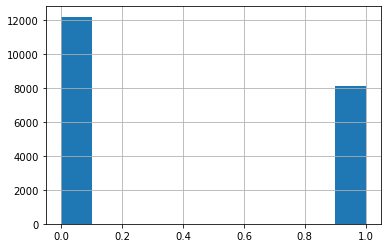

In [38]:
_dataset['umbral'].hist()

  DATOS MENORES A  10  


<AxesSubplot:>

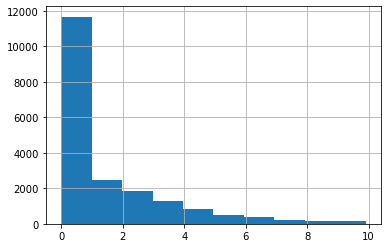

In [35]:
print('  DATOS MENORES A  10  ')
_dataset[_dataset['dato']<10]['dato'].hist()

  DATOS MAYORES A  10  


<AxesSubplot:>

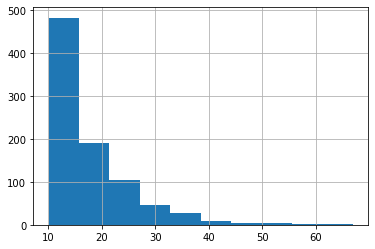

In [36]:
print('  DATOS MAYORES A  10  ')
_dataset[_dataset['dato']>10]['dato'].hist()

In [37]:
print('           ESTADISCIAS\n')

print(f'Flags:      {_dataset["flag"].unique()}')
print(f'Estaciones: {len(_dataset["codigo"].unique())}')
print(f'Totales:    {_dataset["dato"].count()}')
print(f'Atipicos:   {_dataset[_dataset["umbral"]==1]["dato"].count()}')
print(f'Ceros:      {_dataset[_dataset["dato"]==0]["dato"].count()}')
print(f'Maximo:     {_dataset["dato"].max()}')
print(f'Media:      {_dataset["dato"].mean()}')
print(f'STD:        {_dataset["dato"].std()}')

           ESTADISCIAS

Flags:      ['C0000002' 'C0000001']
Estaciones: 170
Totales:    20370
Atipicos:   8148
Ceros:      1112
Maximo:     66.9
Media:      2.144489445262641
STD:        4.104809186606982


In [38]:
"""
# Definimos las varibles para las iteraciones
Los parametros que van a cambiar son:
- Canales (products)
- Tiempos (Min de las imagenes)
- margen
"""
params = {'inputs'   : ['imagen','99%'],
          'outputs'  : 'umbral',  #umbral o dato
          'lr'       : 0.001,
          'batch'    : 32,        
          'dataset'  : 1,
          'epocas'   : 10,          
          'paciencia': 4,
          'canales'  : [3,3,3,3,3,3],
          'tiempos'  : [2,6,2,6,2,6],
          'margen'   : [50,50,110,110,70,70],
          'runs'     : 6
         }

In [39]:
%%time
#Solo imagenes (dato)
resultados = trainModel(params,_dataset,path_imagenes,path_base,products,times, graficos=1)

--------------------------------------------------
Inicio de la prueba N°: 1/6
Creadno modelo con input (50,50,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 0.6433 - acc: 0.6522 - true_positives: 1658.0000 - true_negatives: 8971.0000 - false_positives: 807.0000 - false_negatives: 4860.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_222318.hdf5
510/510 [==============================] - 404s 776ms/step - loss: 0.6433 - acc: 0.6522 - true_positives: 1658.0000 - true_negatives: 8971.0000 - false_positives: 807.0000 - false_negatives: 4860.0000 - val_loss: 0.6350 - val_acc: 0.6588 - val_true_positives: 1493.0000 - val_true_negatives: 9243.0000 - val_false_positives: 535.0000 - val_false_negatives: 5025.0000 - _timestamp: 1650079811.0000 - _runtime: 412.0000
Epoch 2/10
509/510 [============================>.] - ETA: 0s - loss: 0.6321 - acc: 0.6602 - true_positives: 1769.0000 - true_negatives: 8984.0000 - false_positives: 789.0000 - false_negatives: 4746.0000
Epoch 2: saving model to C:/Users/Shounen/Desktop/Cicl

acc,▁▇▇▇█▇
epoch,▁▂▄▅▇█
false_negatives,▅▁▅▇██
false_positives,█▇▄▂▁▁
loss,█▃▂▂▁▁
true_negatives,▁▂▅▇██
true_positives,▄█▄▂▁▁
val_acc,▁█▅▅▅▅
val_false_negatives,▁▃▄███
val_false_positives,█▅▄▁▁▁
val_loss,█▄▃▂▂▁


--------------------------------------------------
Inicio de la prueba N°: 2/6
Creadno modelo con input (50,50,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 0.6416 - acc: 0.6519 - true_positives_1: 1582.0000 - true_negatives_1: 9041.0000 - false_positives_1: 748.0000 - false_negatives_1: 4925.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220415_230529.hdf5
510/510 [==============================] - 1605s 3s/step - loss: 0.6416 - acc: 0.6519 - true_positives_1: 1582.0000 - true_negatives_1: 9041.0000 - false_positives_1: 748.0000 - false_negatives_1: 4925.0000 - val_loss: 0.6335 - val_acc: 0.6627 - val_true_positives_1: 1430.0000 - val_true_negatives_1: 9370.0000 - val_false_positives_1: 419.0000 - val_false_negatives_1: 5077.0000 - _timestamp: 1650083545.0000 - _runtime: 1616.0000
Epoch 2/10
510/510 [==============================] - ETA: 0s - loss: 0.6286 - acc: 0.6653 - true_positives_1: 1747.0000 - true_negatives_1: 9095.0000 - false_positives_1: 694.0000 - false_negatives_1: 4760.0000
Epoch 2: saving model t

acc,▁████
epoch,▁▃▅▆█
false_negatives_1,█▁▃▂▃
false_positives_1,█▄▂▂▁
loss,█▂▂▁▁
true_negatives_1,▁▅▇▇█
true_positives_1,▁█▆▇▆
val_acc,█▁▁▁▁
val_false_negatives_1,▁████
val_false_positives_1,█▁▁▁▁
val_loss,█▄▂▁▁


--------------------------------------------------
Inicio de la prueba N°: 3/6
Creadno modelo con input (110,110,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 0.6481 - acc: 0.6429 - true_positives_2: 1402.0000 - true_negatives_2: 9074.0000 - false_positives_2: 690.0000 - false_negatives_2: 5130.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220416_010935.hdf5
510/510 [==============================] - 378s 739ms/step - loss: 0.6481 - acc: 0.6429 - true_positives_2: 1402.0000 - true_negatives_2: 9074.0000 - false_positives_2: 690.0000 - false_negatives_2: 5130.0000 - val_loss: 0.6328 - val_acc: 0.6617 - val_true_positives_2: 1993.0000 - val_true_negatives_2: 8790.0000 - val_false_positives_2: 974.0000 - val_false_negatives_2: 4539.0000 - _timestamp: 1650089770.0000 - _runtime: 395.0000
Epoch 2/10
509/510 [============================>.] - ETA: 0s - loss: 0.6301 - acc: 0.6625 - true_positives_2: 1924.0000 - true_negatives_2: 8867.0000 - false_positives_2: 895.0000 - false_negatives_2: 4602.0000
Epoch 2: saving model 

acc,▁███████
epoch,▁▂▃▄▅▆▇█
false_negatives_2,█▁▂▃▄▄▄▄
false_positives_2,▃█▅▄▃▂▁▁
loss,█▃▂▁▁▁▁▁
true_negatives_2,▆▁▄▅▆▇██
true_positives_2,▁█▇▆▅▅▅▅
val_acc,▁▁▇████▇
val_false_negatives_2,▁▁▆████▆
val_false_positives_2,██▂▁▁▁▁▂
val_loss,█▄▄▄▂▂▅▁


--------------------------------------------------
Inicio de la prueba N°: 4/6
Creadno modelo con input (110,110,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 0.6471 - acc: 0.6431 - true_positives_3: 1340.0000 - true_negatives_3: 9140.0000 - false_positives_3: 661.0000 - false_negatives_3: 5155.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220416_102702.hdf5
510/510 [==============================] - 1143s 2s/step - loss: 0.6471 - acc: 0.6431 - true_positives_3: 1340.0000 - true_negatives_3: 9140.0000 - false_positives_3: 661.0000 - false_negatives_3: 5155.0000 - val_loss: 0.6303 - val_acc: 0.6577 - val_true_positives_3: 1992.0000 - val_true_negatives_3: 8726.0000 - val_false_positives_3: 1075.0000 - val_false_negatives_3: 4503.0000 - _timestamp: 1650123982.0000 - _runtime: 1160.0000
Epoch 2/10
510/510 [==============================] - ETA: 0s - loss: 0.6302 - acc: 0.6620 - true_positives_3: 1858.0000 - true_negatives_3: 8930.0000 - false_positives_3: 871.0000 - false_negatives_3: 4637.0000
Epoch 2: saving model 

acc,▁▇█████
epoch,▁▂▃▅▆▇█
false_negatives_3,█▁▂▃▃▃▃
false_positives_3,▁█▄▄▃▃▂
loss,█▃▂▁▁▁▁
true_negatives_3,█▁▅▅▆▆▇
true_positives_3,▁█▇▆▆▆▆
val_acc,▁██████
val_false_negatives_3,▁▅█████
val_false_positives_3,█▃▁▁▁▁▁
val_loss,█▄▂▂▁▁▁


--------------------------------------------------
Inicio de la prueba N°: 5/6
Creadno modelo con input (70,70,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 0.6447 - acc: 0.6427 - true_positives_4: 1559.0000 - true_negatives_4: 8915.0000 - false_positives_4: 862.0000 - false_negatives_4: 4960.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220416_130846.hdf5
510/510 [==============================] - 699s 1s/step - loss: 0.6447 - acc: 0.6427 - true_positives_4: 1559.0000 - true_negatives_4: 8915.0000 - false_positives_4: 862.0000 - false_negatives_4: 4960.0000 - val_loss: 0.6293 - val_acc: 0.6637 - val_true_positives_4: 1892.0000 - val_true_negatives_4: 8924.0000 - val_false_positives_4: 853.0000 - val_false_negatives_4: 4627.0000 - _timestamp: 1650133240.0000 - _runtime: 714.0000
Epoch 2/10
509/510 [============================>.] - ETA: 0s - loss: 0.6294 - acc: 0.6625 - true_positives_4: 1840.0000 - true_negatives_4: 8951.0000 - false_positives_4: 821.0000 - false_negatives_4: 4676.0000
Epoch 2: saving model to 

acc,▁█████
epoch,▁▂▄▅▇█
false_negatives_4,█▁▄▅▄▄
false_positives_4,█▇▂▁▂▃
loss,█▃▂▁▁▁
true_negatives_4,▁▂▇█▇▆
true_positives_4,▁█▅▄▅▅
val_acc,▁█████
val_false_negatives_4,▁█████
val_false_positives_4,█▁▁▁▁▁
val_loss,█▄▃▂▁▁


--------------------------------------------------
Inicio de la prueba N°: 6/6
Creadno modelo con input (70,70,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 0.6446 - acc: 0.6437 - true_positives_5: 1485.0000 - true_negatives_5: 9004.0000 - false_positives_5: 763.0000 - false_negatives_5: 5044.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220416_140654.hdf5
510/510 [==============================] - 1652s 3s/step - loss: 0.6446 - acc: 0.6437 - true_positives_5: 1485.0000 - true_negatives_5: 9004.0000 - false_positives_5: 763.0000 - false_negatives_5: 5044.0000 - val_loss: 0.6307 - val_acc: 0.6637 - val_true_positives_5: 1817.0000 - val_true_negatives_5: 8998.0000 - val_false_positives_5: 769.0000 - val_false_negatives_5: 4712.0000 - _timestamp: 1650137676.0000 - _runtime: 1662.0000
Epoch 2/10
509/510 [============================>.] - ETA: 1s - loss: 0.6295 - acc: 0.6613 - true_positives_5: 1784.0000 - true_negatives_5: 8987.0000 - false_positives_5: 775.0000 - false_negatives_5: 4742.0000
Epoch 2: saving model t

acc,▁▇███
epoch,▁▃▅▆█
false_negatives_5,█▁▄▄▄
false_positives_5,██▂▁▁
loss,█▂▂▁▁
true_negatives_5,▁▁▇██
true_positives_5,▁█▅▅▅
val_acc,█▁▁▁▃
val_false_negatives_5,▁████
val_false_positives_5,█▁▁▁▁
val_loss,█▄▃▂▁


CPU times: total: 3d 5h 50min 31s
Wall time: 17h 49min 15s


In [40]:
"""
# Definimos las varibles para las iteraciones
Los parametros que van a cambiar son:
- Canales (products)
- Tiempos (Min de las imagenes)
- margen
"""
params = {'inputs'   : ['imagen','99%'],
          'outputs'  : 'umbral',  #umbral o dato
          'lr'       : 0.001,
          'batch'    : 32,        
          'dataset'  : 1,
          'epocas'   : 10,          
          'paciencia': 4,
          'canales'  : [3,3,3,3,3,3],
          'tiempos'  : [1,4,1,4,1,4],
          'margen'   : [50,50,110,110,70,70],
          'runs'     : 6
         }

In [41]:
%%time
#Solo imagenes (dato)
resultados = trainModel(params,_dataset,path_imagenes,path_base,products,times, graficos=1)

--------------------------------------------------
Inicio de la prueba N°: 1/6
Creadno modelo con input (50,50,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
509/510 [============================>.] - ETA: 0s - loss: 0.6481 - acc: 0.6372 - true_positives_6: 1405.0000 - true_negatives_6: 8974.0000 - false_positives_6: 808.0000 - false_negatives_6: 5101.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220416_161233.hdf5
510/510 [==============================] - 188s 367ms/step - loss: 0.6481 - acc: 0.6373 - true_positives_6: 1407.0000 - true_negatives_6: 8978.0000 - false_positives_6: 809.0000 - false_negatives_6: 5102.0000 - val_loss: 0.6345 - val_acc: 0.6589 - val_true_positives_6: 1987.0000 - val_true_negatives_6: 8750.0000 - val_false_positives_6: 1037.0000 - val_false_negatives_6: 4522.0000 - _timestamp: 1650143760.0000 - _runtime: 207.0000
Epoch 2/10
509/510 [============================>.] - ETA: 0s - loss: 0.6319 - acc: 0.6602 - true_positives_6: 1924.0000 - true_negatives_6: 8830.0000 - false_positives_6: 952.0000 - false_negatives_6: 4582.0000
Epoch 2: saving model

acc,▁█████
epoch,▁▂▄▅▇█
false_negatives_6,█▁▃▄▄▄
false_positives_6,▄█▄▂▁▁
loss,█▃▂▂▁▁
true_negatives_6,▅▁▅▇██
true_positives_6,▁█▆▅▅▅
val_acc,▁███▃█
val_false_negatives_6,▁▄▅▅█▅
val_false_positives_6,█▃▂▂▁▂
val_loss,█▄▃▂▁▁


--------------------------------------------------
Inicio de la prueba N°: 2/6
Creadno modelo con input (50,50,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 0.6391 - acc: 0.6578 - true_positives_7: 1800.0000 - true_negatives_7: 8920.0000 - false_positives_7: 857.0000 - false_negatives_7: 4719.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220416_183242.hdf5
510/510 [==============================] - 914s 2s/step - loss: 0.6391 - acc: 0.6578 - true_positives_7: 1800.0000 - true_negatives_7: 8920.0000 - false_positives_7: 857.0000 - false_negatives_7: 4719.0000 - val_loss: 0.6291 - val_acc: 0.6637 - val_true_positives_7: 1829.0000 - val_true_negatives_7: 8986.0000 - val_false_positives_7: 791.0000 - val_false_negatives_7: 4690.0000 - _timestamp: 1650152894.0000 - _runtime: 932.0000
Epoch 2/10
509/510 [============================>.] - ETA: 0s - loss: 0.6293 - acc: 0.6627 - true_positives_7: 1737.0000 - true_negatives_7: 9057.0000 - false_positives_7: 715.0000 - false_negatives_7: 4779.0000
Epoch 2: saving model to 

acc,▁█▆██
epoch,▁▃▅▆█
false_negatives_7,▁▄▇▇█
false_positives_7,█▄▂▂▁
loss,█▃▂▁▁
true_negatives_7,▁▅▇▇█
true_positives_7,█▅▂▂▁
val_acc,█▁▁▁▁
val_false_negatives_7,▁████
val_false_positives_7,█▁▁▁▁
val_loss,█▄▃▁▁


--------------------------------------------------
Inicio de la prueba N°: 3/6
Creadno modelo con input (110,110,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
509/510 [============================>.] - ETA: 0s - loss: 0.6495 - acc: 0.6374 - true_positives_8: 1302.0000 - true_negatives_8: 9080.0000 - false_positives_8: 637.0000 - false_negatives_8: 5269.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220416_195900.hdf5
510/510 [==============================] - 251s 490ms/step - loss: 0.6495 - acc: 0.6374 - true_positives_8: 1304.0000 - true_negatives_8: 9083.0000 - false_positives_8: 637.0000 - false_negatives_8: 5272.0000 - val_loss: 0.6373 - val_acc: 0.6367 - val_true_positives_8: 2634.0000 - val_true_negatives_8: 7742.0000 - val_false_positives_8: 1978.0000 - val_false_negatives_8: 3942.0000 - _timestamp: 1650157402.0000 - _runtime: 262.0000
Epoch 2/10
509/510 [============================>.] - ETA: 0s - loss: 0.6310 - acc: 0.6600 - true_positives_8: 1888.0000 - true_negatives_8: 8862.0000 - false_positives_8: 855.0000 - false_negatives_8: 4683.0000
Epoch 2: saving model

acc,▁██████
epoch,▁▂▃▅▆▇█
false_negatives_8,█▁▂▃▃▃▃
false_positives_8,▁█▄▂▂▂▂
loss,█▂▂▂▁▁▁
true_negatives_8,█▁▅▇▇▇▇
true_positives_8,▁█▇▆▆▆▆
val_acc,▁▇█████
val_false_negatives_8,▁▇█████
val_false_positives_8,█▂▁▁▁▁▁
val_loss,█▄▃▂▂▁▁


--------------------------------------------------
Inicio de la prueba N°: 4/6
Creadno modelo con input (110,110,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
509/510 [============================>.] - ETA: 1s - loss: 0.6521 - acc: 0.6330 - true_positives_9: 1125.0000 - true_negatives_9: 9186.0000 - false_positives_9: 597.0000 - false_negatives_9: 5380.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220416_202807.hdf5
510/510 [==============================] - 1114s 2s/step - loss: 0.6522 - acc: 0.6330 - true_positives_9: 1127.0000 - true_negatives_9: 9188.0000 - false_positives_9: 598.0000 - false_negatives_9: 5383.0000 - val_loss: 0.6333 - val_acc: 0.6551 - val_true_positives_9: 2368.0000 - val_true_negatives_9: 8307.0000 - val_false_positives_9: 1479.0000 - val_false_negatives_9: 4142.0000 - _timestamp: 1650160011.0000 - _runtime: 1124.0000
Epoch 2/10
510/510 [==============================] - ETA: 0s - loss: 0.6311 - acc: 0.6603 - true_positives_9: 1978.0000 - true_negatives_9: 8783.0000 - false_positives_9: 1003.0000 - false_negatives_9: 4532.0000
Epoch 2: saving model

acc,▁▇████
epoch,▁▂▄▅▇█
false_negatives_9,█▁▃▃▃▄
false_positives_9,▁█▄▃▂▂
loss,█▃▂▁▁▁
true_negatives_9,█▁▅▆▇▇
true_positives_9,▁█▆▆▆▅
val_acc,▁█▆▆██
val_false_negatives_9,▁▇████
val_false_positives_9,█▂▁▁▁▁
val_loss,█▄▃▂▁▁


--------------------------------------------------
Inicio de la prueba N°: 5/6
Creadno modelo con input (70,70,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
509/510 [============================>.] - ETA: 0s - loss: 0.6424 - acc: 0.6480 - true_positives_10: 1649.0000 - true_negatives_10: 8905.0000 - false_positives_10: 834.0000 - false_negatives_10: 4900.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220416_221550.hdf5
510/510 [==============================] - 190s 369ms/step - loss: 0.6424 - acc: 0.6480 - true_positives_10: 1650.0000 - true_negatives_10: 8909.0000 - false_positives_10: 835.0000 - false_negatives_10: 4902.0000 - val_loss: 0.6331 - val_acc: 0.6603 - val_true_positives_10: 1538.0000 - val_true_negatives_10: 9222.0000 - val_false_positives_10: 522.0000 - val_false_negatives_10: 5014.0000 - _timestamp: 1650165557.0000 - _runtime: 207.0000
Epoch 2/10
509/510 [============================>.] - ETA: 0s - loss: 0.6288 - acc: 0.6635 - true_positives_10: 1928.0000 - true_negatives_10: 8879.0000 - false_positives_10: 860.0000 - false_negatives_10: 4621.0000
Epoch 

acc,▁█████
epoch,▁▂▄▅▇█
false_negatives_10,█▁▄▇▇▇
false_positives_10,▇█▄▁▁▁
loss,█▃▂▁▁▁
true_negatives_10,▂▁▅███
true_positives_10,▁█▅▂▂▂
val_acc,▁█▁▁▁▁
val_false_negatives_10,█▁████
val_false_positives_10,▁█▁▁▁▁
val_loss,█▂▁▂▁▁


--------------------------------------------------
Inicio de la prueba N°: 6/6
Creadno modelo con input (70,70,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
509/510 [============================>.] - ETA: 0s - loss: 0.6525 - acc: 0.6343 - true_positives_11: 1045.0000 - true_negatives_11: 9287.0000 - false_positives_11: 499.0000 - false_negatives_11: 5457.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220417_081105.hdf5
510/510 [==============================] - 1056s 2s/step - loss: 0.6525 - acc: 0.6343 - true_positives_11: 1048.0000 - true_negatives_11: 9289.0000 - false_positives_11: 499.0000 - false_negatives_11: 5460.0000 - val_loss: 0.6358 - val_acc: 0.6460 - val_true_positives_11: 2558.0000 - val_true_negatives_11: 7969.0000 - val_false_positives_11: 1819.0000 - val_false_negatives_11: 3950.0000 - _timestamp: 1650202133.0000 - _runtime: 1068.0000
Epoch 2/10
509/510 [============================>.] - ETA: 0s - loss: 0.6336 - acc: 0.6586 - true_positives_11: 1921.0000 - true_negatives_11: 8807.0000 - false_positives_11: 979.0000 - false_negatives_11: 4581.0000
Epoch 

acc,▁▇████
epoch,▁▂▄▅▇█
false_negatives_11,█▁▂▃▃▄
false_positives_11,▁█▆▄▃▂
loss,█▃▂▁▁▁
true_negatives_11,█▁▃▅▆▇
true_positives_11,▁█▇▆▆▅
val_acc,▁██▇██
val_false_negatives_11,▁▇▇███
val_false_positives_11,█▂▂▁▁▁
val_loss,█▄▂▁▁▁


CPU times: total: 2d 7min 46s
Wall time: 17h 24min 19s


In [47]:
"""
# Definimos las varibles para las iteraciones
Los parametros que van a cambiar son:
- Canales (products)
- Tiempos (Min de las imagenes)
- margen
"""
params = {'inputs'   : ['imagen','99%'],
          'outputs'  : 'umbral',  #umbral o dato
          'lr'       : 0.001,
          'batch'    : 32,        
          'dataset'  : 1,
          'epocas'   : 10,          
          'paciencia': 4,
          'canales'  : [3],
          'tiempos'  : [6],
          'margen'   : [40],
          'runs'     : 1
         }

In [48]:
%%time
#Solo imagenes (dato)
resultados = trainModel(params,_dataset,path_imagenes,path_base,products,times, graficos=1)

--------------------------------------------------
Inicio de la prueba N°: 1/1
Creadno modelo con input (40,40,3)) tipo (umbral)
DONE
Tamaño del dataset: Train 16296  - Val 4074
- Batch size:  32


Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 0.6387 - acc: 0.6535 - true_positives_14: 1691.0000 - true_negatives_14: 8959.0000 - false_positives_14: 845.0000 - false_negatives_14: 4801.0000
Epoch 1: saving model to C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Modelos\Model_20220417_094602.hdf5
510/510 [==============================] - 1884s 4s/step - loss: 0.6387 - acc: 0.6535 - true_positives_14: 1691.0000 - true_negatives_14: 8959.0000 - false_positives_14: 845.0000 - false_negatives_14: 4801.0000 - val_loss: 0.6301 - val_acc: 0.6611 - val_true_positives_14: 1518.0000 - val_true_negatives_14: 9256.0000 - val_false_positives_14: 548.0000 - val_false_negatives_14: 4974.0000 - _timestamp: 1650208656.0000 - _runtime: 1894.0000
Epoch 2/10
509/510 [============================>.] - ETA: 1s - loss: 0.6297 - acc: 0.6613 - true_positives_14: 1647.0000 - true_negatives_14: 9124.0000 - false_positives_14: 676.0000 - false_negatives_14: 4841.0000
Epoch 2

acc,▁████▇
epoch,▁▂▄▅▇█
false_negatives_14,▁▃▇▇█▆
false_positives_14,█▄▁▂▁▂
loss,█▃▂▁▁▁
true_negatives_14,▁▅█▇█▇
true_positives_14,█▆▂▂▁▃
val_acc,▁█▆▆▆▆
val_false_negatives_14,▁▆████
val_false_positives_14,█▂▁▁▁▁
val_loss,█▄▃▂▁▁


CPU times: total: 19h 14min
Wall time: 2h 26min 58s
